In [1]:
#import the libraries
import os
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [3]:
#Loading the dataset
data_path = "/kaggle/input/traffic-signs-preprocessed"

def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

train_data = load_pickle(os.path.join(data_path, "train.pickle"))
valid_data = load_pickle(os.path.join(data_path, "valid.pickle"))
test_data = load_pickle(os.path.join(data_path, "test.pickle"))

print("Train keys:", train_data.keys())
print("Training images shape:", train_data['features'].shape)
print("Training labels shape:", train_data['labels'].shape)


Train keys: dict_keys(['coords', 'labels', 'features', 'sizes'])
Training images shape: (34799, 32, 32, 3)
Training labels shape: (34799,)


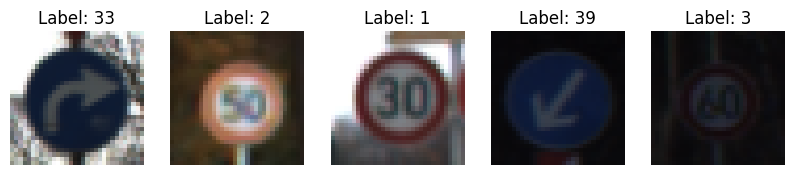

In [4]:
#Checking the dataset structure
def show_sample_images(features, labels, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        idx = np.random.randint(0, len(features))
        plt.subplot(1, n, i+1)
        plt.imshow(features[idx])
        plt.title(f"Label: {labels[idx]}")
        plt.axis('off')
    plt.show()

show_sample_images(train_data['features'], train_data['labels'])


In [5]:
#Custom dataset class
class TrafficSignDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        image = self.features[idx]
        label = self.labels[idx]

        # Convert image to tensor and normalize
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [15]:
#Create dataset and dataloaders
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
])

test_transform = transforms.Compose([])  

# Create dataset objects
train_dataset = TrafficSignDataset(train_data['features'], train_data['labels'], transform=train_transform)
valid_dataset = TrafficSignDataset(valid_data['features'], valid_data['labels'], transform=test_transform)
test_dataset = TrafficSignDataset(test_data['features'], test_data['labels'], transform=test_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [8]:
#Define transform
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
])

test_transform = transforms.Compose([])  


In [9]:
train_dataset = TrafficSignDataset(train_data['features'], train_data['labels'], transform=train_transform)
valid_dataset = TrafficSignDataset(valid_data['features'], valid_data['labels'], transform=test_transform)
test_dataset = TrafficSignDataset(test_data['features'], test_data['labels'], transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [13]:
#CNN model

class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(TrafficSignCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x



In [15]:
#Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TrafficSignCNN(num_classes=43).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [16]:
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 2.4373
Epoch [2/10], Loss: 1.1037
Epoch [3/10], Loss: 0.6173
Epoch [4/10], Loss: 0.4221
Epoch [5/10], Loss: 0.3090
Epoch [6/10], Loss: 0.2498
Epoch [7/10], Loss: 0.1998
Epoch [8/10], Loss: 0.1759
Epoch [9/10], Loss: 0.1533
Epoch [10/10], Loss: 0.1342


In [17]:
#Model evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 91.67%


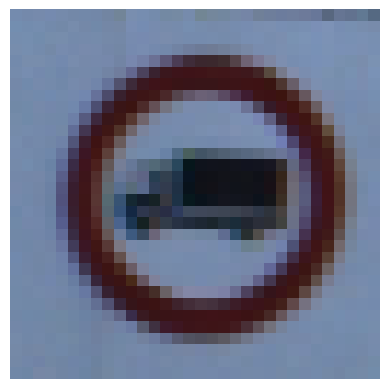

Predicted: 16, Actual: 16


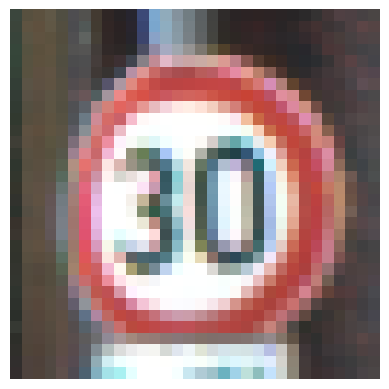

Predicted: 1, Actual: 1


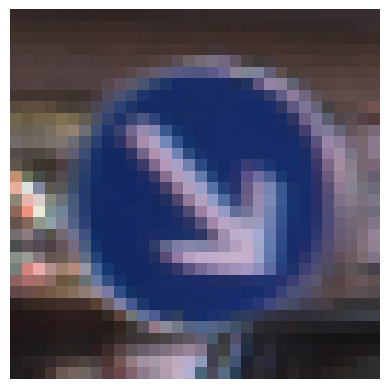

Predicted: 38, Actual: 38


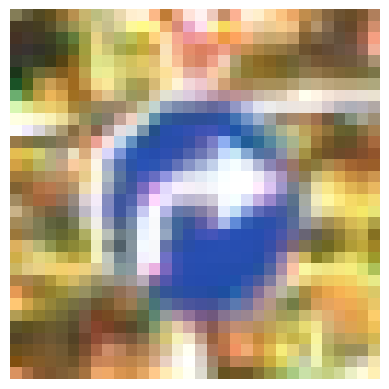

Predicted: 33, Actual: 33


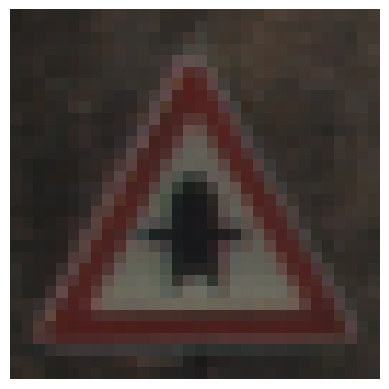

Predicted: 11, Actual: 11


In [18]:
#Visualization
def imshow(img):
    np_img = img.numpy().transpose((1, 2, 0))
    plt.imshow(np_img)
    plt.axis('off')
    plt.show()

images, labels = next(iter(test_loader))
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

for i in range(5):
    imshow(images[i])
    print(f"Predicted: {preds[i].item()}, Actual: {labels[i].item()}")


In [19]:
torch.save(model.state_dict(), "traffic_sign_model.pth")
print("Model saved successfully!")


Model saved successfully!
